In [19]:
import sqlite3
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import math

def load_data() -> tuple[pd.DataFrame, pd.DataFrame]:
    #connect to the data.db database
    conn = sqlite3.connect('data.db')
    cursor = conn.cursor()

    #joining the tables based on foreign keys
    query = """
    SELECT
    c.id AS client_id,
    c.age,
    c.job,
    c.marital,
    c.education,
    a.balance,
    a.in_default,
    a.housing,
    a.loan,
    ca.duration,
    ca.campaign,
    ca.pdays,
    ca.previous,
    o.poutcome,
    o.y
    FROM Clients c
    JOIN Accounts a ON c.id = a.client_id
    JOIN Campaigns ca ON a.id = ca.account_id
    JOIN Outcomes o ON ca.id = o.campaign_id;
    """

    # Execute the query and fetch the result into a DataFrame
    merged_df = pd.read_sql_query(query, conn)
    total_customers = len(merged_df)
    # Make basic filtering: 
    # 1. remove customers with negative balancce
    merged_df = merged_df[ merged_df["balance"] > 0 ]
    positive_balance_customers = len(merged_df)
    # 2 remove customers who are in default
    merged_df = merged_df[ merged_df["in_default"]  == "no" ]
    good_customers = len(merged_df)
    print("total", total_customers, 
          "positive", positive_balance_customers,
          "good customers", good_customers)

    train_and_test_df = merged_df[(merged_df.y == 'yes') | (merged_df.y =='no')]
    prediction_df = merged_df[merged_df.y=='unknown']
    prediction_df = prediction_df.drop("y", axis=1)

    return train_and_test_df, prediction_df


train_and_test_df, prediction_df = load_data()

total 45211 positive 37931 good customers 37672


In [20]:
def total_return(num_reached, balances, alpha=0.1): 
    return -2 * num_reached + alpha * sum(balances)
# -2 * num_reached: This represents the cost of reaching out to num_reached individuals.
# calculates the total balance (or value) associated with the individuals reached.
# 
def avg_return(num_reached, balances, alpha=0.1):
    return total_return(num_reached, balances, alpha) / num_reached



In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Sample data creation (replace this with your actual DataFrame)
np.random.seed(42)

# Separate features and target variable
X = train_and_test_df[prediction_df.columns.drop("client_id")]
y = train_and_test_df["y"] == "yes"

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing: Encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

# Create a pipeline that includes preprocessing and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1],
    'classifier__colsample_bytree': [0.8, 1],
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2
)

# Fit the model using grid search
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters found:  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}


c:\anaconda\envs\dwwshop\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
reached_customers = X_val.loc[y_pred == 1] 
converted_customers = X_val.loc[(y_pred == 1) & (y_val == 1)]
num_reached = len(reached_customers)
num_converted = len(converted_customers)
conversion_ratio = num_converted / num_reached
expected_avg_return = avg_return(num_reached, reached_customers["balance"])
actual_avg_return = avg_return(num_reached, converted_customers["balance"])
return_ratio = actual_avg_return / expected_avg_return
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation ROC AUC: {roc_auc:.4f}')
print(f"Number of reached customers", num_reached)
print(f"Number of converted customers", num_converted)
print(f"Expected avg return", expected_avg_return)
print(f"Actual avg return", actual_avg_return)
print("Conversion ratio", conversion_ratio)
print("Avg return ratio", return_ratio)


Validation Accuracy: 0.8874
Validation ROC AUC: 0.8502
Number of reached customers 42
Number of converted customers 24
Expected avg return 179.65952380952382
Actual avg return 69.63095238095238
Conversion ratio 0.5714285714285714
Avg return ratio 0.38757172959433844


In [23]:
# Make predictions
X_future = prediction_df.drop("client_id", axis=1)
y_future = best_model.predict(X_future)

In [24]:
# alphas = np.linspace(0, .05, 50)
# results = []
# for alpha in alphas:
#     expected_avg_return = avg_return(num_reached, reached_customers["balance"], alpha=alpha)
#     actual_avg_return = avg_return(num_reached, converted_customers["balance"], alpha=alpha)
#     return_ratio = abs(actual_avg_return / expected_avg_return)
#     #if actual_avg_return < 0 or expected_avg_return < 0:
#     #  return_ratio = 1

#     future_reached_customers = X_future.loc[y_future == 1]
#     future_num_reached = len(future_reached_customers)
#     future_expected_avg_return = avg_return(future_num_reached, future_reached_customers["balance"], alpha=alpha)
#     print(alpha, 
#           future_expected_avg_return * return_ratio,
#           sep="\t")
#     results.append(future_expected_avg_return * return_ratio)

# plt.plot(alphas * 100, results)
# plt.xlabel("Bank's interest rate %")
# plt.ylabel("$ earnings per contacted customer")

In [25]:
alpha = 0.05
expected_avg_return = avg_return(num_reached, reached_customers["balance"], alpha=alpha)
actual_avg_return = avg_return(num_reached, converted_customers["balance"], alpha=alpha)
return_ratio = abs(actual_avg_return / expected_avg_return)
    #if actual_avg_return < 0 or expected_avg_return < 0:
    #  return_ratio = 1

future_reached_customers = X_future.loc[y_future == 1]
future_num_reached = len(future_reached_customers)
future_expected_avg_return = avg_return(future_num_reached, future_reached_customers["balance"], alpha=alpha)
print(alpha, 
    future_expected_avg_return * return_ratio,
    sep="\t")

0.05	40.05932307039494


In [26]:
conversion_ratio_future = num_converted / num_reached

In [27]:
return_ratio

0.38067732554243666

In [28]:
future_num_reached

2279

In [29]:
future_expected_total_return = total_return(future_num_reached, future_reached_customers["balance"], alpha=alpha)
future_expected_total_return

239823.05000000002

In [30]:
client_ids_to_reach = prediction_df.loc[y_future == 1, "client_id"].copy()
# client_ids_to_reach.name = "target"
# client_ids_to_reach.to_csv("second_phase_target.csv", index=False)

In [31]:
# Filter using .isin()
og_table = pd.read_csv("merged_table.csv")
filtered_table = og_table[og_table['client_id'].isin(list(client_ids_to_reach))]
filtered_table.balance.max()

81204.0

In [36]:
from sklearn.metrics import classification_report, roc_auc_score
classification_report_test_group = classification_report(y_val, y_pred, output_dict=True)
classification_report_test_group

{'False': {'precision': 0.906030855539972,
  'recall': 0.9728915662650602,
  'f1-score': 0.9382716049382716,
  'support': 664.0},
 'True': {'precision': 0.5714285714285714,
  'recall': 0.26373626373626374,
  'f1-score': 0.3609022556390977,
  'support': 91.0},
 'accuracy': 0.8874172185430463,
 'macro avg': {'precision': 0.7387297134842716,
  'recall': 0.618313915000662,
  'f1-score': 0.6495869302886846,
  'support': 755.0},
 'weighted avg': {'precision': 0.8657013087132999,
  'recall': 0.8874172185430463,
  'f1-score': 0.8686813919763845,
  'support': 755.0}}

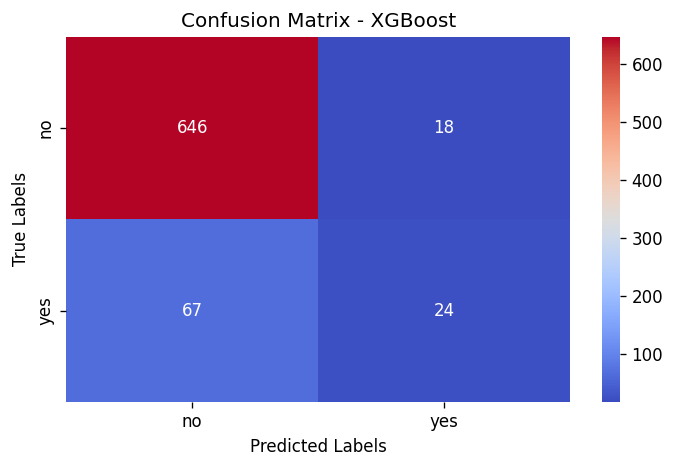

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix for XGBoost
xgb_conf_matrix = confusion_matrix(y_val, best_model.predict(X_val))

# Plot the confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
sns.heatmap(xgb_conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=['no', 'yes'], yticklabels=['no', 'yes'], ax=ax)
ax.set_title("Confusion Matrix - XGBoost")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

plt.tight_layout()
plt.show()


In [ ]:
# import dash
# from dash import dcc, html
# from dash.dependencies import Input, Output
# import pandas as pd
# import plotly.express as px

# # Load the dataset
# data = pd.read_csv("merged_table.csv")

# # Start the Dash app
# app = dash.Dash(__name__)

# # Extract column names for the dropdown
# columns = data.columns

# # Layout of the Dash app
# app.layout = html.Div([
#     html.H1("EDA Dashboard", style={'textAlign': 'center'}),
    
#     # Dropdown for column selection
#     html.Div([
#         html.Label("Select Column for Visualization:"),
#         dcc.Dropdown(
#             id="column-dropdown",
#             options=[{"label": col, "value": col} for col in columns],
#             value=columns[0]
#         )
#     ], style={'width': '50%', 'margin': '0 auto'}),
    
#     # Graph for EDA
#     dcc.Graph(id="eda-graph")
# ])

# # Callback to update the graph based on selected column
# @app.callback(
#     Output("eda-graph", "figure"),
#     [Input("column-dropdown", "value")]
# )
# def update_graph(selected_column):
#     """
#     Update graph based on the selected column from the dropdown menu.
#     """
#     if data[selected_column].dtype in ['int64', 'float64']:
#         # Numerical column: use histogram
#         fig = px.histogram(data, x=selected_column, title=f"Distribution of {selected_column}")
#     else:
#         # Categorical column: use bar chart
#         category_counts = data[selected_column].value_counts().reset_index()
#         category_counts.columns = [selected_column, 'count']  # Rename columns
#         fig = px.bar(category_counts, x=selected_column, y='count', title=f"Frequency of {selected_column}")
#         fig.update_layout(xaxis_title=selected_column, yaxis_title="Count")
    
#     return fig

# # Run the app
# if __name__ == "__main__":
#     app.run_server(debug=True)
